In [13]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
    #     sigma = np.random.rand(1,size) + 0.5
    #     for index in range(size):
    #         def f0(sig):
    #             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
    #         res = spo.minimize(f0,sigma[0,index])
    #         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

#Now add in a bias
def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0, initial=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
#     x[0] = npr.rand(1,size)-0.5
    print(initial)
    x[0] = initial
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    opd = odd_power(delta,1/power)
    if not np.isscalar(delta):
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias
    else:
        return x,w,sigma,bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    def f0(bias):
        return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     if power<3:
#         y /= y_max[None,:]#now y is definitely within +/- 1
#         x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/sp.special.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig, bias = infer(dataset[patient].transpose(), power=given_power)
        allwmatrices[patient] = w
        allsigs[patient] = sig
        allbiases[patient] = bias
    return allwmatrices, allsigs, allbiases

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs, allbiases = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [3]:
power = 7
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [8]:
allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 7


(1018, 10)
[ 2.25967063 -1.35739182 -0.87810466  1.17927246  0.76127643  0.17435729
 -0.59544978 -1.27179613  0.16279199  0.12141886]
(1018, 10)


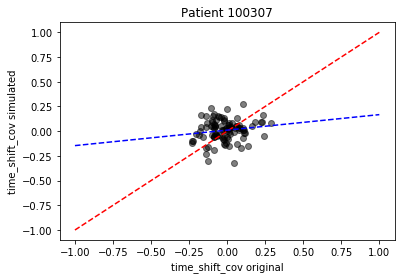

Slope:  0.15673387308972028 P-Value:  0.11868829907826048
--------------------------------------------------------------
(1018, 10)
[-0.45509862 -3.66954124  1.96567049  1.05858226 -1.81973115 -0.10068622
 -1.26844896  0.27987676 -1.02642955 -0.22036491]
(1018, 10)


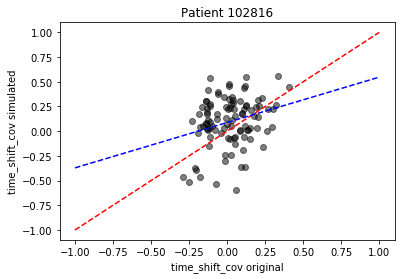

Slope:  0.4590793771178178 P-Value:  0.0067999996923195204
--------------------------------------------------------------
(1018, 10)
[-3.17724381  2.40185458 -0.5027215   2.47893274  1.05574736  2.11566465
  0.86142091  0.83420441 -2.26465247  0.17691149]
(1018, 10)


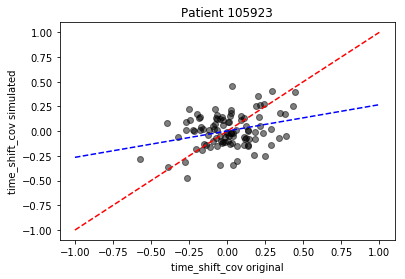

Slope:  0.2664273770676884 P-Value:  0.0029635943186622775
--------------------------------------------------------------
(1018, 10)
[ 1.95199688  0.45531682  1.31600582 -6.86535717  1.44912238 -0.14123129
  1.42838439  0.41539245  1.37875633  2.16866375]
(1018, 10)


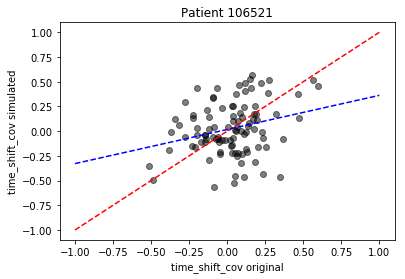

Slope:  0.3452518962363359 P-Value:  0.00757896724183938
--------------------------------------------------------------
(1018, 10)
[-2.50715721  0.94691558 -2.64871412  0.06972636  1.23558114  2.40134846
 -1.94759228 -1.0934236  -0.57041284 -0.44236417]
(1018, 10)


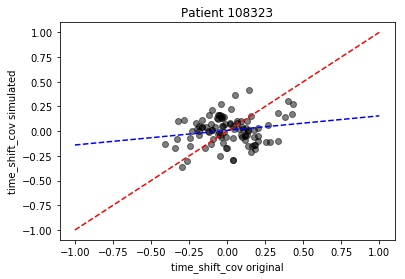

Slope:  0.14740515530646037 P-Value:  0.07093818071611314
--------------------------------------------------------------
(1018, 10)
[-0.93147245  1.14834619 -1.81071918 -0.0037066   1.03626366 -0.00347023
  0.12135458  1.00155338  0.2458663   1.19073637]
(1018, 10)


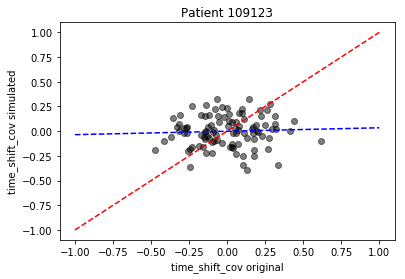

Slope:  0.034823881438231494 P-Value:  0.6434316608043326
--------------------------------------------------------------
(1018, 10)
[ 8.5717613  -3.3153834   1.76722441 -2.34516861 -0.87994341  2.0740789
  4.19464882 -0.74472204 -0.16413216 -1.78229208]
(1018, 10)


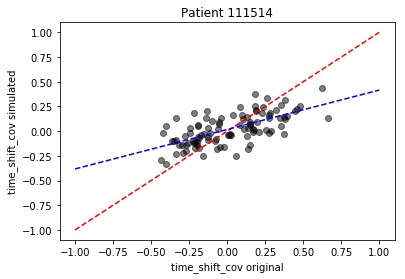

Slope:  0.39919542404366287 P-Value:  1.7373204008930927e-13
--------------------------------------------------------------
(1018, 10)
[ 9.50163074 -3.68275116  1.81641298  0.95603007  2.51861221  1.69636693
  3.97985071  0.67254351 -1.35350536  0.70858861]
(1018, 10)


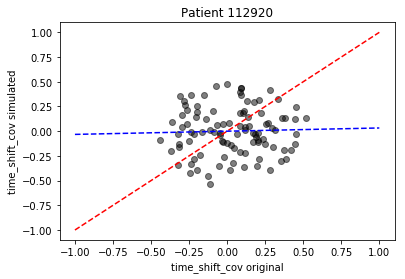

Slope:  0.032453133979576346 P-Value:  0.7507062397061002
--------------------------------------------------------------
(1018, 10)
[ 2.03125068  1.75184256 -0.38119404  0.21146827  2.11216584 -1.15481928
  0.0641689  -0.14166083 -2.27642685 -0.20591388]
(1018, 10)


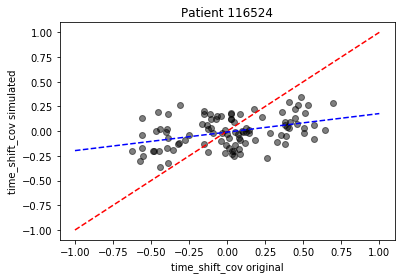

Slope:  0.18734772291069457 P-Value:  5.4941619400841233e-05
--------------------------------------------------------------
(1018, 10)
[-0.26466551  3.77375517 -4.67091291  1.96455411 -4.37741925  0.84790274
  4.61396007  1.59203019  1.51599845  0.47819994]
(1018, 10)


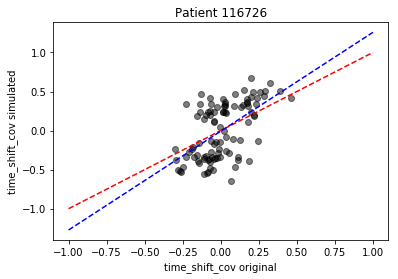

Slope:  1.264808330658311 P-Value:  1.0643136835608226e-09
--------------------------------------------------------------
(1018, 10)
[ 0.85412181  0.03158872 -0.95776079  0.22809361 -0.19391225 -2.12857114
  0.0070477  -0.55170457  0.3541622  -0.60837629]
(1018, 10)


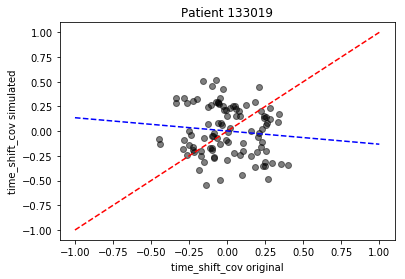

Slope:  -0.13398668831538668 P-Value:  0.3067926640550441
--------------------------------------------------------------
(1018, 10)
[ 0.7746662   2.41056109  0.1340215  -0.68167671  1.19726228  0.72842297
 -0.48738181  0.64942385 -0.48672664  0.44500827]
(1018, 10)


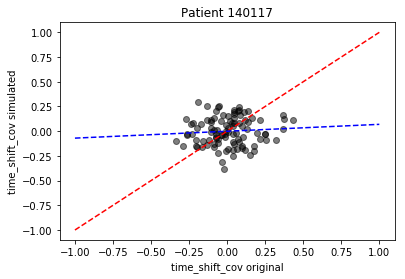

Slope:  0.0697436100049207 P-Value:  0.45233709187954796
--------------------------------------------------------------
(1018, 10)
[ 1.02286427  1.38929374  0.4349367  -0.78425532  0.52975439  0.98430816
 -0.10718562  0.58872524 -0.43038278  0.9066207 ]
(1018, 10)


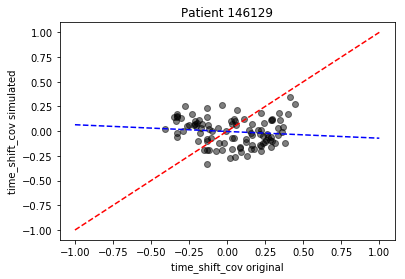

Slope:  -0.0681336287972016 P-Value:  0.2729705161037351
--------------------------------------------------------------
(1018, 10)
[ 5.87764564 -3.88435005  1.3434305   0.20505454  2.15961352  0.84709448
 -1.02411897 -1.86178048  0.52190581 -0.39361106]
(1018, 10)


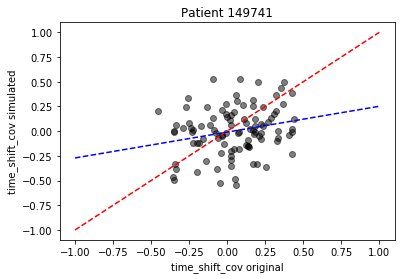

Slope:  0.2615967370992341 P-Value:  0.017869386419639983
--------------------------------------------------------------
(1018, 10)
[-5.01711188 -0.07567921 -1.5892931  -1.02654301 -2.08015098  0.5775363
  1.57099232  1.67797516 -0.56773198 -2.08076889]
(1018, 10)


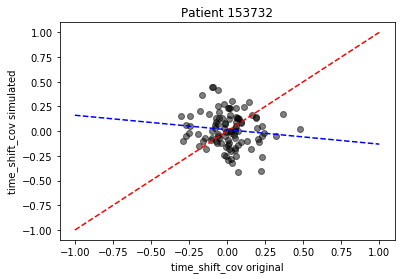

Slope:  -0.14618686824617338 P-Value:  0.24922638567002206
--------------------------------------------------------------
(1018, 10)
[ 1.44487194 -2.13886106 -5.4799348   1.2662652   0.91725374  2.28883758
  0.6748498   0.14628877  1.78219075  0.90478189]
(1018, 10)


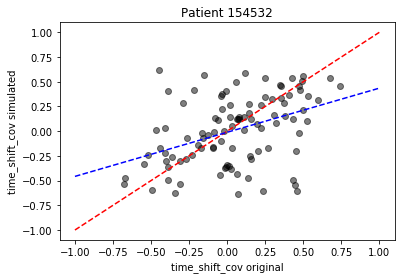

Slope:  0.4464380325765701 P-Value:  1.669106809940621e-05
--------------------------------------------------------------
(1018, 10)
[-1.08649411 -0.55362623  0.32480505 -1.05075871  0.43981952 -0.22517835
 -1.79118454  0.20066811  0.42052706  0.85937532]
(1018, 10)


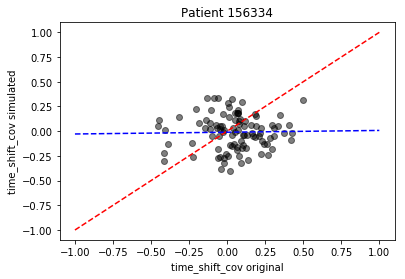

Slope:  0.017900929635814477 P-Value:  0.8435291959976312
--------------------------------------------------------------
(1018, 10)
[ 0.18833736  0.07703836  2.00626809 -2.11879269 -1.31400291  1.07087211
 -0.2272166  -0.05058659 -0.72431083 -1.50943831]
(1018, 10)


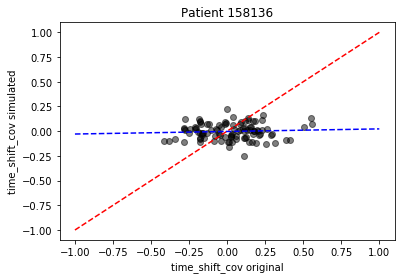

Slope:  0.025905954153182423 P-Value:  0.5308508384055426
--------------------------------------------------------------
(1018, 10)
[-1.03367674 -2.15120936 -2.36142603  0.23895833 -0.50094177  0.08959794
  0.21885333 -0.01375783  0.4239878   0.08270183]
(1018, 10)


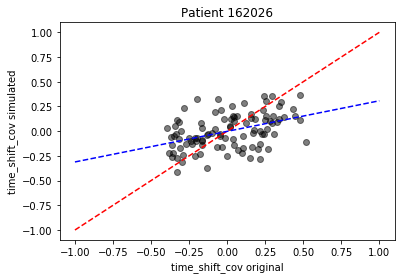

Slope:  0.3094464419305702 P-Value:  8.150803663371107e-06
--------------------------------------------------------------
(1018, 10)
[-1.83392693 -1.17816835 -1.6276535   6.86908791 -3.55622189 -2.48634986
  1.35018378 -0.65331057  2.1883508  -0.78890622]
(1018, 10)


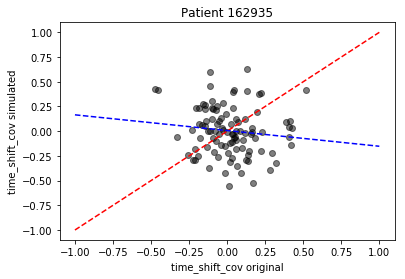

Slope:  -0.1590030094697427 P-Value:  0.23381922236543728
--------------------------------------------------------------
(1018, 10)
[-2.43465542  0.16473317 -1.94107104 -4.74019183  0.36772389  0.38182666
  0.73644949 -0.09275781 -2.48389221  0.76192936]
(1018, 10)


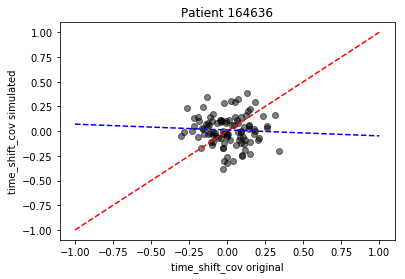

Slope:  -0.0592547766518485 P-Value:  0.6046259469170038
--------------------------------------------------------------
(1018, 10)
[ 1.05544987 -1.42918185 -3.1988971   0.30216287  1.62356815  0.4812888
 -0.31936384  0.84724937 -0.66651924 -0.73766707]
(1018, 10)


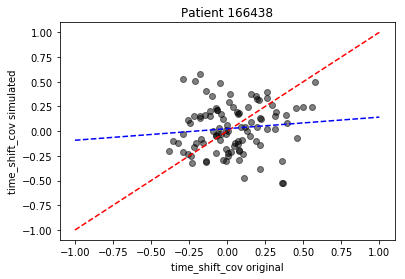

Slope:  0.1169383016383342 P-Value:  0.3113305592326431
--------------------------------------------------------------
(1018, 10)
[ 4.23744291 -5.31090069  3.7701038   0.04539604 -2.03676744  0.48827904
 -0.35787803  1.81067234  0.61610147  0.36817884]
(1018, 10)


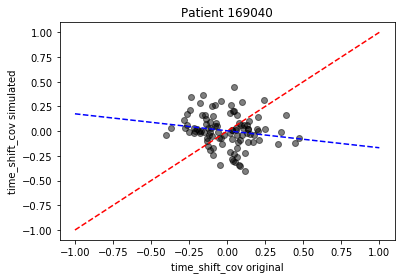

Slope:  -0.17173247002820569 P-Value:  0.08325703383261149
--------------------------------------------------------------
(1018, 10)
[ 3.79356796  0.14236218 -0.35760223  0.3285367  -1.60723536 -1.96905589
 -3.03293959 -0.18883713 -0.05031999 -1.03998074]
(1018, 10)


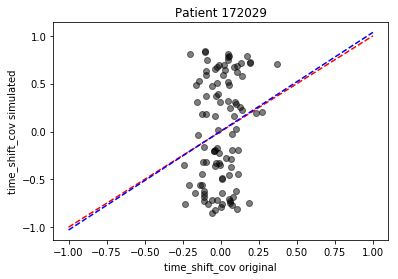

Slope:  1.0330024423802968 P-Value:  0.03863687476792179
--------------------------------------------------------------
(1018, 10)
[ 2.13259287 -5.24450346 -1.87328195  0.82642624  1.22224361 -0.61662957
  0.1324121  -0.48566724 -0.82699452 -0.34905256]
(1018, 10)


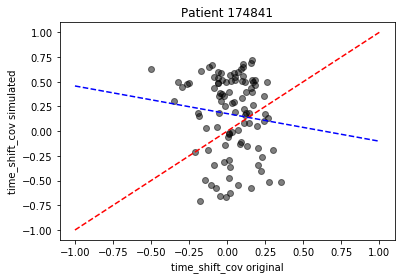

Slope:  -0.27945421092118944 P-Value:  0.2869638178556065
--------------------------------------------------------------
(1018, 10)
[ 8.76890313 -0.50094856  2.51505258  1.16794062  0.4728662   1.17534504
 -0.71529575  2.48878186 -0.62926792  0.31727116]
(1018, 10)


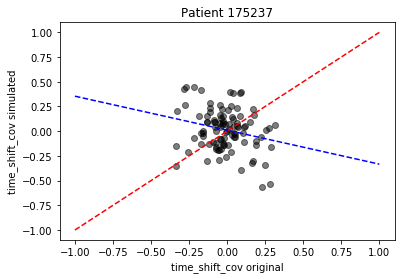

Slope:  -0.34375003431716017 P-Value:  0.017586837824955643
--------------------------------------------------------------
(1018, 10)
[ 3.87895925  1.39794909 -0.26201045 -0.28169474  1.83625803  0.82976883
  0.30228475  1.3993491  -0.52533926  0.7268337 ]
(1018, 10)


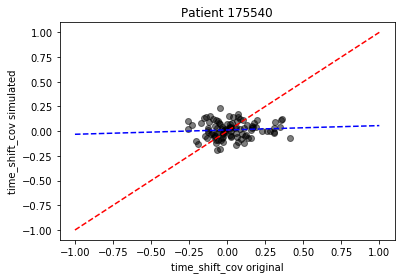

Slope:  0.04386305093881255 P-Value:  0.44890080987298653
--------------------------------------------------------------
(1018, 10)
[ 0.81658694 -1.57434518  0.488386    4.01415963 -3.08043888 -0.09760027
  1.16413289 -1.00154045  1.18725204  0.21226816]
(1018, 10)


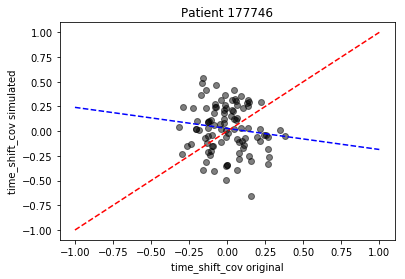

Slope:  -0.21306612599884342 P-Value:  0.19214930729965476
--------------------------------------------------------------
(1018, 10)
[ 5.84823894 -0.09784338 -0.57460119  1.94141378 -0.55930241  0.33627698
 -0.78797063 -0.49795009  3.08012459  1.56239552]
(1018, 10)


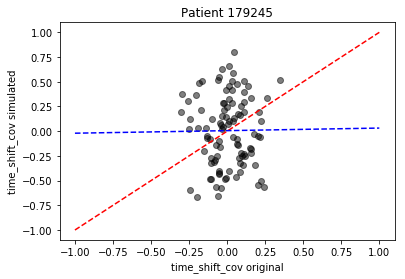

Slope:  0.025931167624195985 P-Value:  0.9241976939826015
--------------------------------------------------------------
(1018, 10)
[-5.07709116 -6.75427518 -2.20163665  3.98722954  0.88955137 -2.23805987
  3.53554935  1.84639507  0.41982966  2.70622184]
(1018, 10)


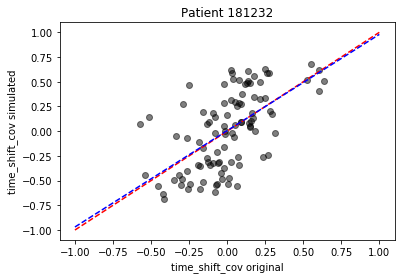

Slope:  0.9742619171680108 P-Value:  7.473073102600753e-11
--------------------------------------------------------------
(1018, 10)
[-1.63533546  0.58231105  0.2838967  -0.45435033  1.13520552  2.00597406
 -0.51427667  0.80892096 -0.6101318  -0.02396177]
(1018, 10)


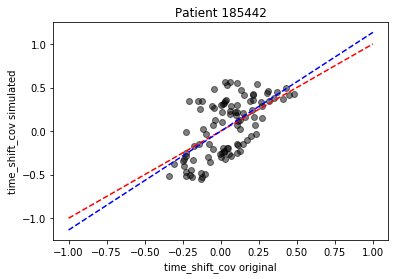

Slope:  1.1340022088193895 P-Value:  3.5670889461042145e-12
--------------------------------------------------------------
(1018, 10)
[-0.83249304  2.31368788 -1.49125232 -0.70802074  0.83711123  1.14507958
  0.02727651 -1.2475636   0.22816296  0.80612621]
(1018, 10)


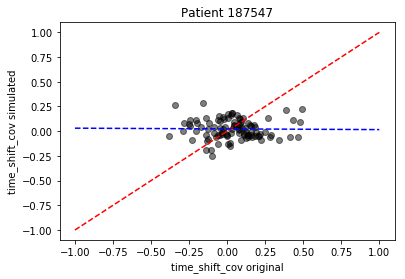

Slope:  -0.007221498886188992 P-Value:  0.8980327406567685
--------------------------------------------------------------
(1018, 10)
[-1.31541037 -3.30514802 -0.08587833 -1.1240027   1.55446741  0.19013186
 -1.52436731  2.30710184  2.29910963 -0.4866933 ]
(1018, 10)


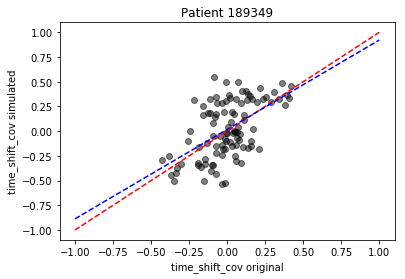

Slope:  0.9048197075179862 P-Value:  2.0260460452787137e-09
--------------------------------------------------------------
(1018, 10)
[ 6.68553508 -4.71561836 -1.94249417  0.38372137  1.21170106  0.01482565
 -0.1378298   2.72877768  0.04118414 -1.17197414]
(1018, 10)


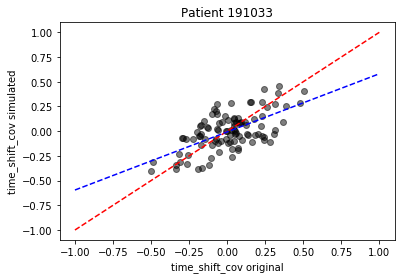

Slope:  0.5880777937502719 P-Value:  5.146995050619482e-12
--------------------------------------------------------------
(1018, 10)
[-2.33499456 -3.84419592 -4.89667897  4.31007133 -1.19735281 -0.91258359
  0.41576974  0.84417949  0.7757252  -1.651232  ]
(1018, 10)


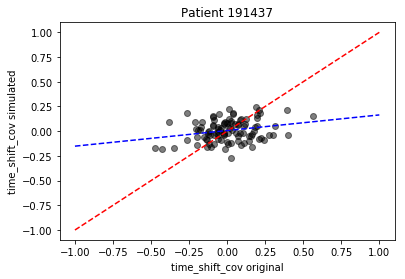

Slope:  0.15795463626655912 P-Value:  0.01210562120976608
--------------------------------------------------------------
(1018, 10)
[-0.83356044 -4.9142954   1.50009697  3.60924004 -0.54263262 -3.01531014
  1.75227949 -1.5884778  -1.82232833  1.39649892]
(1018, 10)


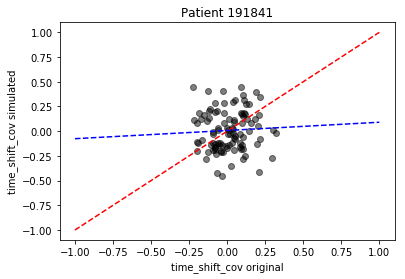

Slope:  0.08315634964516588 P-Value:  0.6202121760499117
--------------------------------------------------------------
(1018, 10)
[-1.6434045   4.81761564  3.61716263 -1.49631707 -0.6386191  -1.10816666
  0.8703473  -0.23391199  4.26862156  1.57940301]
(1018, 10)


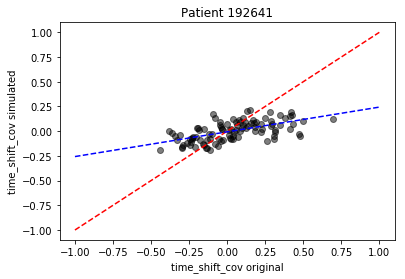

Slope:  0.25026775293252573 P-Value:  1.31673565600053e-10
--------------------------------------------------------------
(1018, 10)
[ 0.90734567 -2.80685881  1.13762649 -3.30125848 -1.38852518  0.7523238
  1.16778883 -0.0134704   0.49545598  0.69220202]
(1018, 10)


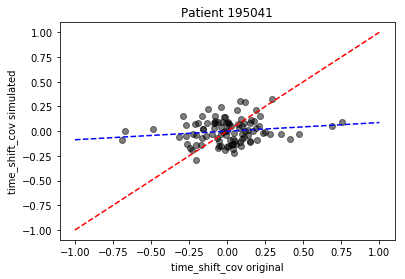

Slope:  0.0869516926967302 P-Value:  0.12749341937335096
--------------------------------------------------------------
(1018, 10)
[-3.24570298  2.28789206 -4.29816394 -2.93061366 -4.08633279  1.0552138
 -0.9709104  -0.58603178  1.13173246  2.18234632]
(1018, 10)


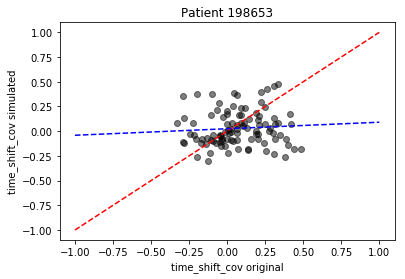

Slope:  0.06595864674185768 P-Value:  0.47849412943568526
--------------------------------------------------------------
(1018, 10)
[ 0.66058938 -0.68114141 -0.59927141 -2.81143567  2.48760945  0.02111569
 -1.87870231  0.49746086  1.3604688   0.35114452]
(1018, 10)


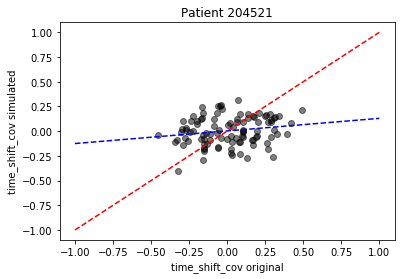

Slope:  0.12739688380918787 P-Value:  0.06741320579617247
--------------------------------------------------------------
(1018, 10)
[ 1.08154835  0.11215609  3.6134079   1.35071665  1.50990419  1.31499266
  1.29051967 -0.49731682 -1.24784102  1.77664822]
(1018, 10)


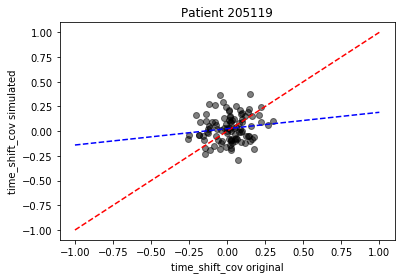

Slope:  0.16544376246303338 P-Value:  0.17140349473858724
--------------------------------------------------------------
(1018, 10)
[ 1.54955894e+00  8.50589290e-01  5.67797728e-02  1.62606074e+00
 -2.05845735e+00 -6.80757164e-01  3.04163948e+00  2.24947332e-03
  1.38215736e+00  5.04510454e-01]
(1018, 10)


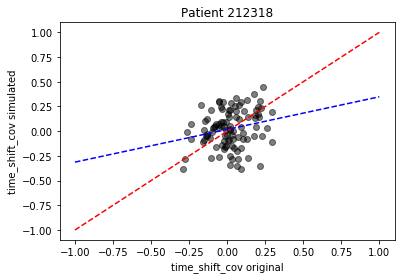

Slope:  0.3304056003967785 P-Value:  0.02624272872212176
--------------------------------------------------------------
(1018, 10)
[ 0.36470823  7.32256479 -0.74791666  0.6379552   1.77749011 -1.82124516
 -1.06519162 -0.57576068  0.10278452  0.33644275]
(1018, 10)


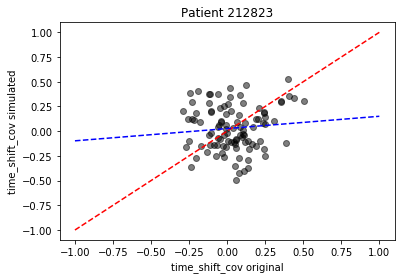

Slope:  0.12413916586625272 P-Value:  0.34696897792150483
--------------------------------------------------------------
(1018, 10)
[-11.86871298   3.53006103   0.62030943  -1.32553976   0.1219193
   1.23493637  -0.54512114  -1.12534285   0.9579564    0.01273095]
(1018, 10)


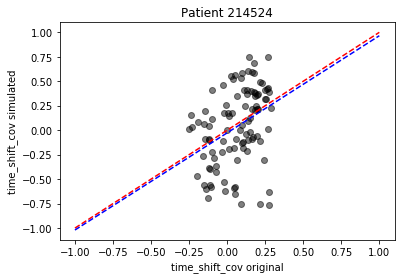

Slope:  0.9925437250883107 P-Value:  0.00020084825997487236
--------------------------------------------------------------
(1018, 10)
[-1.81868941 -1.93174085  1.48635299 -1.41777302  0.9988819  -1.79928794
 -0.68414029 -0.80941934 -0.02898568 -1.6052619 ]
(1018, 10)


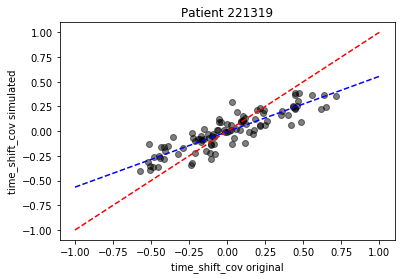

Slope:  0.560419320841707 P-Value:  1.0593531849595795e-33
--------------------------------------------------------------
(1018, 10)
[ 1.1950691   0.935438   -0.71039945  0.61843838  0.83472475  0.33842441
 -1.58287374 -0.1368286  -0.24430962  0.10081488]
(1018, 10)


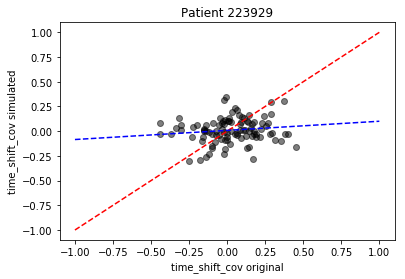

Slope:  0.09244434061721986 P-Value:  0.18113442391418022
--------------------------------------------------------------
(1018, 10)
[-0.97784419  4.89521612 -0.76677571  0.09992117 -1.25935283  0.2068856
 -0.02562862 -0.01585565 -0.84490838 -1.98871154]
(1018, 10)


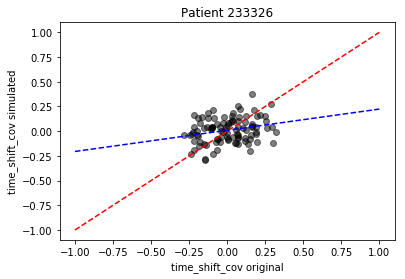

Slope:  0.21435667317256663 P-Value:  0.00991161485994723
--------------------------------------------------------------
(1018, 10)
[-1.20408275 -2.13740358 -1.36979457 -0.63360476  1.25099947  0.29652415
  0.55623185 -0.22813408 -0.68363045  0.76112617]
(1018, 10)


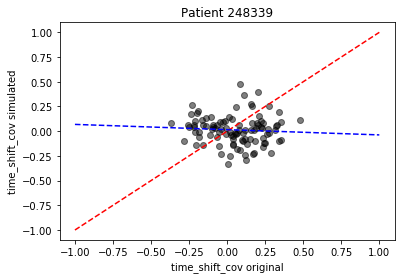

Slope:  -0.05314568285965864 P-Value:  0.5149914141409107
--------------------------------------------------------------
(1018, 10)
[-7.03947788 -7.30478928  1.46616261 -1.9861974   0.97026784  1.23079461
 -2.67673399 -1.74891543 -0.11646845  0.3361725 ]
(1018, 10)


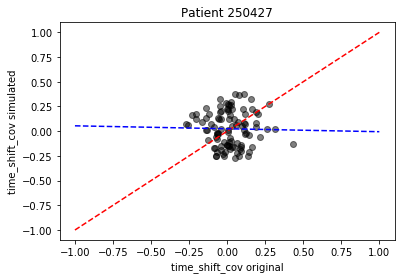

Slope:  -0.029767438344304398 P-Value:  0.8402807993054491
--------------------------------------------------------------
(1018, 10)
[-6.41398505  3.06407556 -1.37251504  1.81745711 -3.50295066  3.03173241
  1.5916224   0.32716012  1.17583263  0.47169585]
(1018, 10)


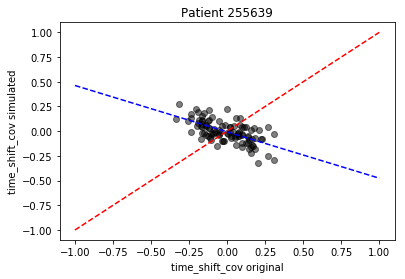

Slope:  -0.4690799922375993 P-Value:  3.5196397504350594e-12
--------------------------------------------------------------
(1018, 10)
[ 0.36930435 -0.28141036  1.46558445 -0.48731689 -0.0344444  -0.01870727
 -1.09160163  0.26237166 -0.82737805  0.79787057]
(1018, 10)


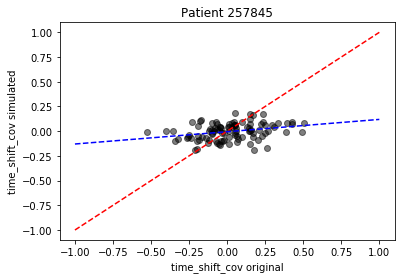

Slope:  0.12441973849789686 P-Value:  0.0027551635332197797
--------------------------------------------------------------
(1018, 10)
[-1.79039345 -3.41049463  0.80379613  0.16545001 -1.04239416  0.38291414
 -0.22625647  1.54146659 -1.30320604 -0.97130281]
(1018, 10)


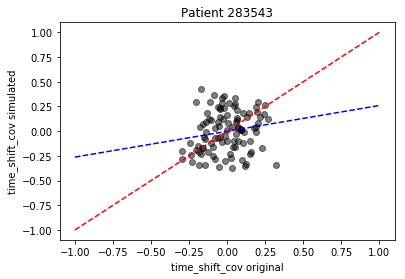

Slope:  0.2608603967283556 P-Value:  0.08239010944676918
--------------------------------------------------------------
(1018, 10)
[-2.33865739  0.51011723  2.07041279  4.37481082  3.29068424  2.23659849
  0.87916374 -1.65483732  0.42788714 -1.36872846]
(1018, 10)


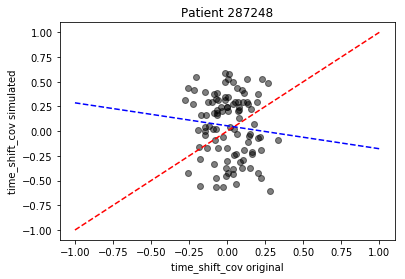

Slope:  -0.23222454290491903 P-Value:  0.3455224418084948
--------------------------------------------------------------
(1018, 10)
[ 0.26942567 -3.71184057 -1.69630942  0.5083178   0.25511116  2.00097447
  2.65855469  0.271487    0.55599815 -1.83159416]
(1018, 10)


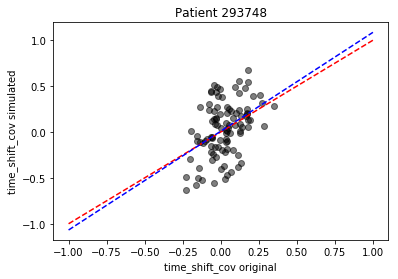

Slope:  1.0769800203196054 P-Value:  1.2582215353190739e-05
--------------------------------------------------------------
(1018, 10)
[ 1.89728995 -1.47555895 -1.9325656  -1.03767273  2.17521557  0.0332212
  1.93884313 -1.73047152  0.53255728  0.77717177]
(1018, 10)


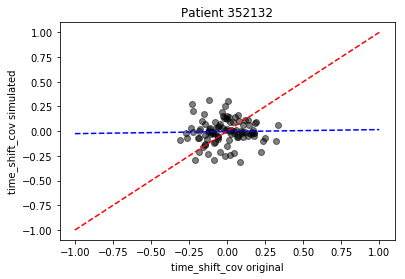

Slope:  0.02045344117305906 P-Value:  0.8259596629375279
--------------------------------------------------------------
(1018, 10)
[-2.6670803  -3.34458105  1.94210148  0.25497481 -0.0120353  -1.06530323
  0.85188075 -0.0633138  -1.63895687 -1.01278149]
(1018, 10)


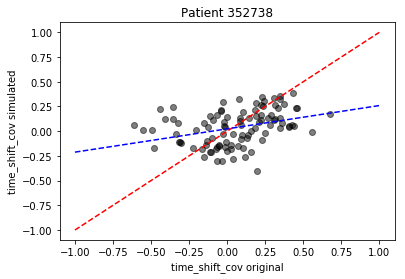

Slope:  0.2356324751599361 P-Value:  0.00046942923091696973
--------------------------------------------------------------
(1018, 10)
[ 1.2281254   4.16659863 -0.15591869 -1.41415966  0.17573507  1.11594283
  0.62905333 -1.85223912  2.11854048  1.16765578]
(1018, 10)


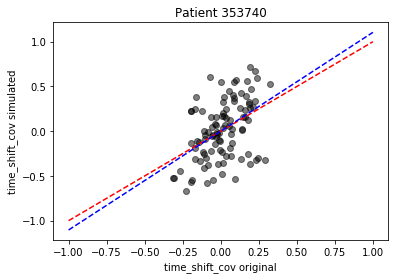

Slope:  1.104507478544728 P-Value:  1.2373797461608668e-06
--------------------------------------------------------------
(1018, 10)
[ 2.38988775  1.07183327  1.18688203  0.30010731  1.14147373 -0.22472322
  3.53663344 -0.11949608 -0.25269499 -0.69609185]
(1018, 10)


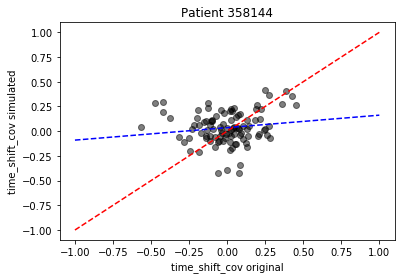

Slope:  0.12613615796673355 P-Value:  0.15385970423620737
--------------------------------------------------------------
(1018, 10)
[-0.99043798  0.84973308 -0.04846008  3.24252208  4.9335792  -2.05783398
  1.91391557  0.54556955  3.12579577 -0.34229492]
(1018, 10)


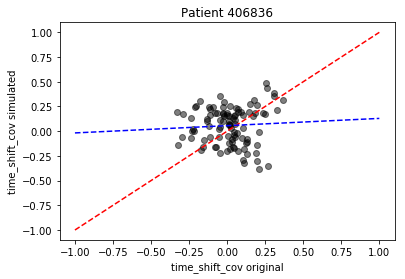

Slope:  0.07343012740532542 P-Value:  0.5609517915440281
--------------------------------------------------------------
(1018, 10)
[-3.27646532  0.33330426 -0.43568773  1.39967261  1.99047063  0.34983735
  1.95582548  1.81211663 -1.96911982  0.90443558]
(1018, 10)


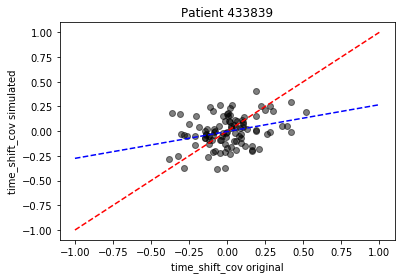

Slope:  0.27142792484419004 P-Value:  0.0021310632737711224
--------------------------------------------------------------
(1018, 10)
[-3.76406663 -2.5634559   1.38233879 -0.99307107 -0.49202895  0.34092805
 -0.55065167  0.15771522  0.91382078 -0.13809932]
(1018, 10)


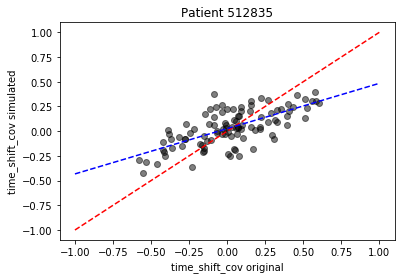

Slope:  0.4582291140458166 P-Value:  4.776095741877686e-15
--------------------------------------------------------------
(1018, 10)
[ 0.52976433  4.02764717  1.76309311 -0.79006611  1.39579053 -0.16388701
  0.97228956 -0.03291923 -0.7719953  -1.18076698]
(1018, 10)


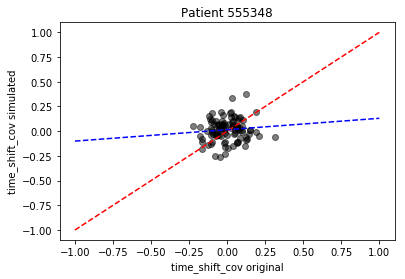

Slope:  0.11528653656550394 P-Value:  0.3228039663774531
--------------------------------------------------------------
(1018, 10)
[ 2.39670577  3.44739202 -0.48426693 -4.35853642  0.89860499  0.43547344
 -2.32366462  1.38387328  1.55786096  1.67239938]
(1018, 10)


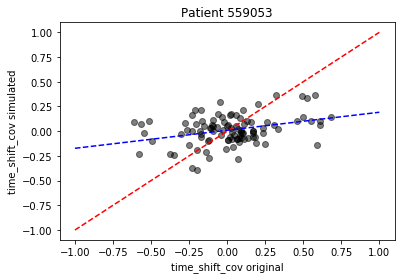

Slope:  0.18238143838543208 P-Value:  0.000668020109421785
--------------------------------------------------------------
(1018, 10)
[ 1.98270374 -4.67530544  3.10792613 -0.7412838   4.07123602 -2.07284741
  3.00249636  0.55494759  0.8193279  -0.16755987]
(1018, 10)


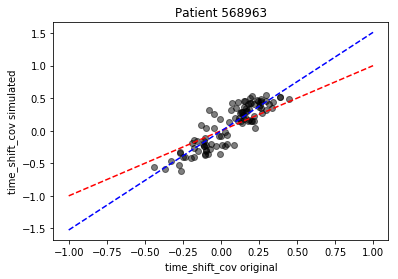

Slope:  1.5182980623891587 P-Value:  6.0594885282878125e-34
--------------------------------------------------------------
(1018, 10)
[ 7.91842896 -0.12548796 -4.03940799 -5.58974252 -5.71720777 -0.65809257
  1.36899379  4.40685501  0.02868172  1.09599412]
(1018, 10)


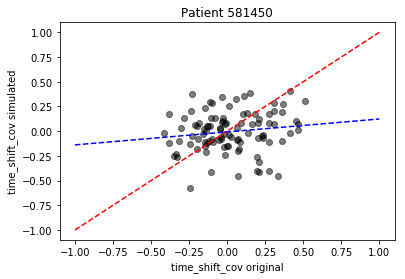

Slope:  0.13095572929239593 P-Value:  0.15681611795333247
--------------------------------------------------------------
(1018, 10)
[ 2.48821759  1.7259885   0.88098835  1.88491623  2.31415952  1.30390186
 -0.42113492 -0.10869738 -1.69192621 -0.37788421]
(1018, 10)


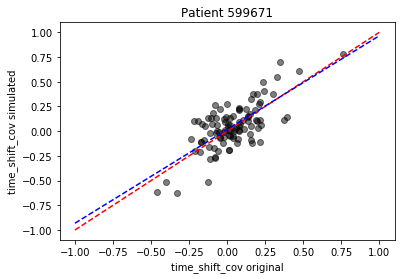

Slope:  0.948310121091541 P-Value:  1.2842571331171932e-17
--------------------------------------------------------------
(1018, 10)
[-0.37261431 -2.09961077 -0.77573919 -0.61841684 -0.75055299 -1.55672992
 -0.1709197   1.02217441 -1.3176036   0.53493859]
(1018, 10)


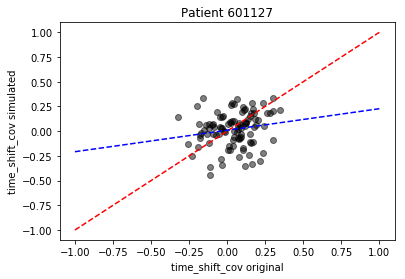

Slope:  0.21752377287540794 P-Value:  0.08209230084788055
--------------------------------------------------------------
(1018, 10)
[ 2.07062528  0.74138414 -1.38433851  0.16879128  0.60946951  2.83274883
  0.16122085 -1.00059912  0.35875131  0.99810789]
(1018, 10)


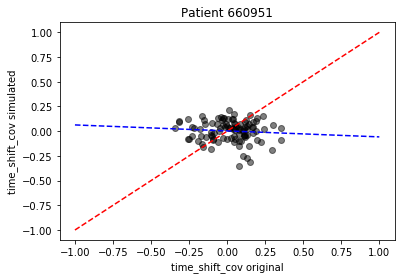

Slope:  -0.060485585229621615 P-Value:  0.4063878894631904
--------------------------------------------------------------
(1018, 10)
[ 1.93589171  4.63194285 -1.78822679  4.38807599  0.02573706  1.31302015
  1.52163461  1.12112312  0.13328647 -0.58234583]
(1018, 10)


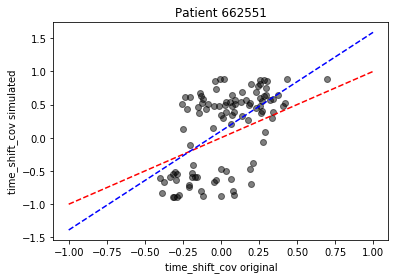

Slope:  1.4887357956171514 P-Value:  5.227401772804808e-10
--------------------------------------------------------------
(1018, 10)
[ 4.06005846  1.38392264  0.69783312 -1.75691844 -1.83470698 -1.10944596
 -1.71398451  1.89621316 -0.96162183 -0.33384035]
(1018, 10)


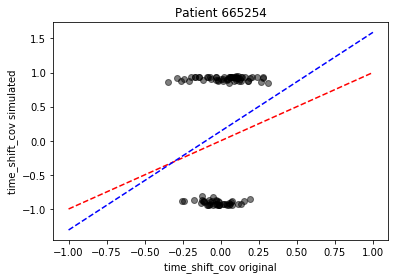

Slope:  1.4484327513846773 P-Value:  0.03459773075820663
--------------------------------------------------------------
(1018, 10)
[-6.41294263  2.0029626  -4.82594426  4.05043541 -0.24873575 -0.7724274
 -1.60758041 -1.34373371  0.82097547  1.64041622]
(1018, 10)


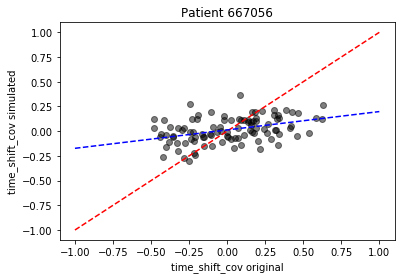

Slope:  0.18585682319957517 P-Value:  3.2330736539615075e-05
--------------------------------------------------------------
(1018, 10)
[-0.34387732 -0.37306283  3.23170088 -2.62253171  1.62384898 -1.97767415
  1.90416426 -1.31041126  0.27105972 -0.68781869]
(1018, 10)


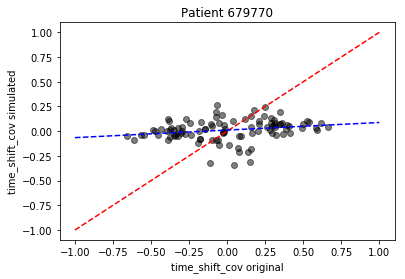

Slope:  0.07660962956472687 P-Value:  0.024502778039860992
--------------------------------------------------------------
(1018, 10)
[ 1.07724281 -1.047651   -3.49161785 -0.07755567 -0.67251919 -0.14769346
  0.54688581 -0.60660116 -0.70645936 -0.35624567]
(1018, 10)


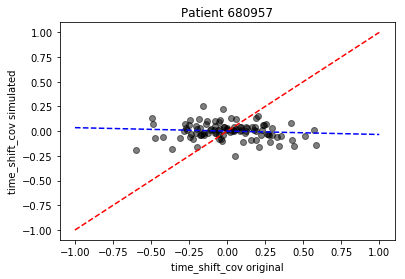

Slope:  -0.034527130329812895 P-Value:  0.3398360665503285
--------------------------------------------------------------
(1018, 10)
[ 0.96105626  0.61793089 -1.95084204  2.41322615  0.93609411  1.20141113
  0.39029502  0.44794756 -1.11288957  0.34428966]
(1018, 10)


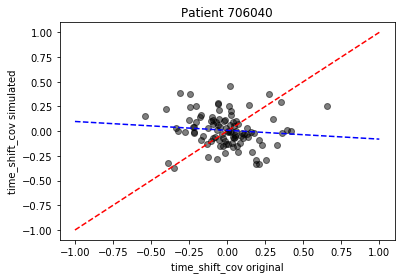

Slope:  -0.08922627699518693 P-Value:  0.3164555578448062
--------------------------------------------------------------
(1018, 10)
[-1.28062342  1.86231553  1.31054222  0.95174067 -0.29822381  1.99819803
 -0.76382889  0.75150834 -0.22945801  0.87456388]
(1018, 10)


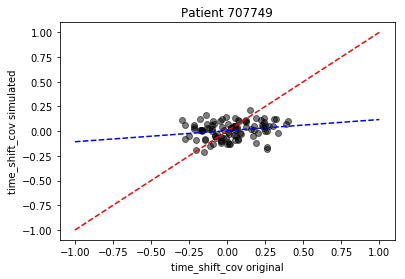

Slope:  0.11229693052601288 P-Value:  0.03597891046116238
--------------------------------------------------------------
(1018, 10)
[ 5.65481057 -0.02693145  1.61881386  0.68051487 -0.70652285 -1.8556676
  0.53510657  1.44109487  0.18507895 -2.58134085]
(1018, 10)


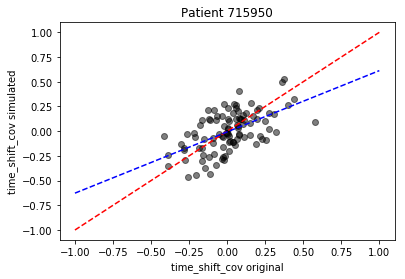

Slope:  0.6197584894429311 P-Value:  9.34009794545936e-10
--------------------------------------------------------------
(1018, 10)
[-0.01623241  0.16106085 -0.55829233 -0.13615434  2.24886925  2.2349048
  0.27357715 -0.23958064  0.25475773  0.86138364]
(1018, 10)


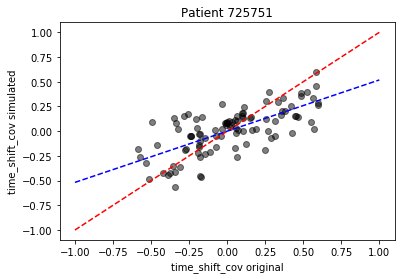

Slope:  0.5182105980546338 P-Value:  9.571118900959765e-16
--------------------------------------------------------------
(1018, 10)
[ 1.05987329 -1.83578319  0.12169408 -2.28154492 -0.32572077  0.33193453
  2.30579505 -1.18948479 -1.97055044 -0.68403767]
(1018, 10)


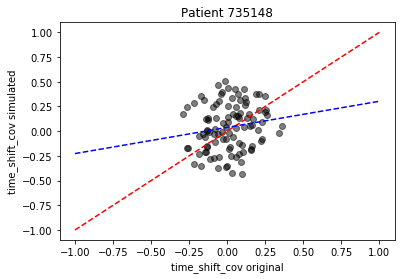

Slope:  0.2646485256461586 P-Value:  0.10922333692894005
--------------------------------------------------------------
(1018, 10)
[-2.66619526  2.67384056 -0.97681013 -1.46678192 -1.75134964  0.23774741
 -1.64832835  0.8287796   2.15118723  1.45049488]
(1018, 10)


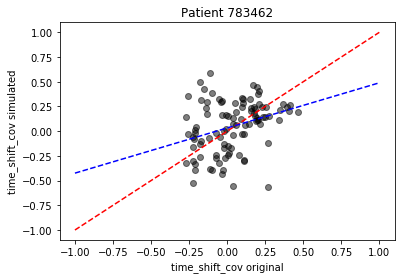

Slope:  0.4568942002846382 P-Value:  0.0012192207713885139
--------------------------------------------------------------
(1018, 10)
[ 2.60428769  1.7209343  -0.66503103  0.3298227   0.81893899  3.32168442
 -2.59036844  1.089361   -0.50643297  0.8116965 ]
(1018, 10)


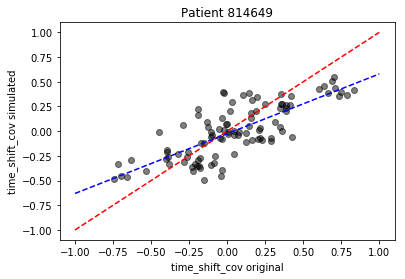

Slope:  0.604798641837285 P-Value:  6.409131018433484e-21
--------------------------------------------------------------
(1018, 10)
[-0.03456245  0.87973584 -3.06663946 -2.17498573 -0.04920317 -0.18318835
 -0.51230925  0.32562847 -0.3527277   0.43715546]
(1018, 10)


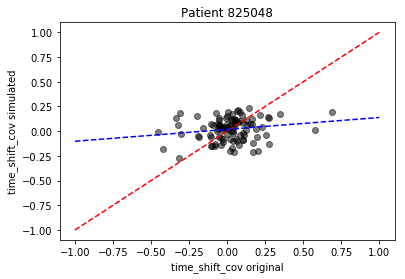

Slope:  0.12014196491720461 P-Value:  0.07606681099836685
--------------------------------------------------------------
(1018, 10)
[-0.311438    6.35824193 -4.28530612 -4.73662347  3.45327045 -0.02032276
 -1.80139852  1.67958975  0.14171836 -0.64330843]
(1018, 10)


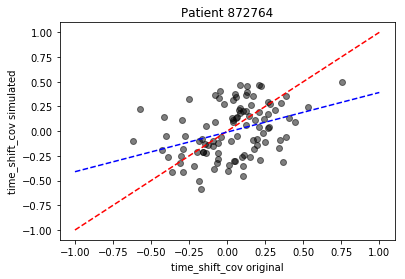

Slope:  0.4007957737279407 P-Value:  0.00019408844740649207
--------------------------------------------------------------
(1018, 10)
[ 4.01127976  4.7565772   0.1363079  -5.65429593  0.48167689 -0.15689151
 -0.65124962 -0.81691512  0.1979134  -0.21742938]
(1018, 10)


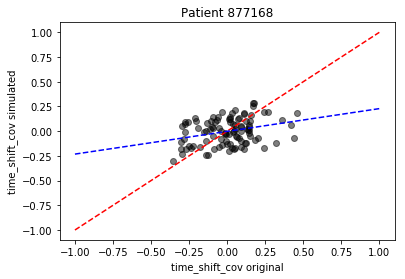

Slope:  0.23001169470311505 P-Value:  0.002199205962777168
--------------------------------------------------------------
(1018, 10)
[ 0.07285602 -2.01304013 -1.52269096 -0.2926078   1.25887178  2.69957624
  0.03033096  1.23634268  0.75110679 -1.169067  ]
(1018, 10)


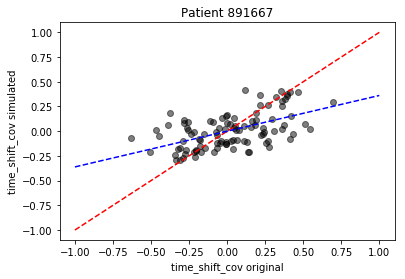

Slope:  0.3614641066523175 P-Value:  4.291538609289726e-09
--------------------------------------------------------------
(1018, 10)
[ 7.10749667 -2.61517618 -1.26177276  0.79878097 -1.8944184   0.77287619
 -1.41383053  0.66702453  0.21163427  0.51736771]
(1018, 10)


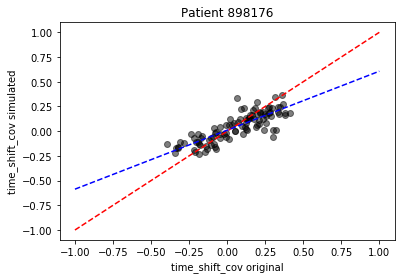

Slope:  0.5967271650309592 P-Value:  4.431200107430923e-26
--------------------------------------------------------------
(1018, 10)
[-0.92648565  1.10561141  1.29898275  1.43491148 -2.06594502  0.81654616
 -1.19514477 -0.17035015 -1.48371596 -0.40291549]
(1018, 10)


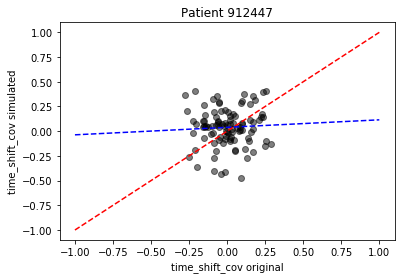

Slope:  0.07583506920029545 P-Value:  0.6012017111295247
--------------------------------------------------------------
(1018, 10)
[-2.18807275  0.19865682  0.27534653 -0.51271183  0.22952749 -1.5290857
 -0.1756269   0.92134047 -0.47533231 -0.01443892]
(1018, 10)


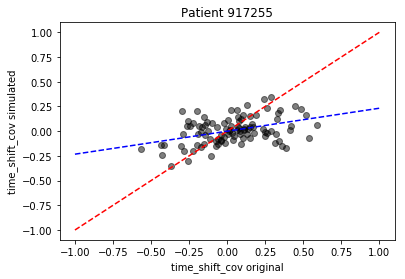

Slope:  0.23243810190836917 P-Value:  2.699841288689889e-05
--------------------------------------------------------------
(1018, 10)
[-0.79793905 -0.54612817 -1.77634208  1.34844974  0.92965334 -0.44978196
  0.5208228  -0.60124196  0.06153334 -0.18103953]
(1018, 10)


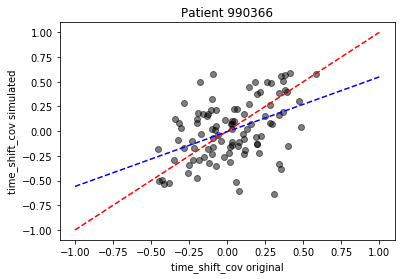

Slope:  0.5539961280813347 P-Value:  3.733788228445684e-06
--------------------------------------------------------------
mean 0.18403950536546487
std 0.2564403602588947
0.2858992270699471


In [17]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_array = []
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()
    print(x_original.shape)

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=7, bias=bias, initial=x_original[0])
    print(simulated_data[0].shape)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=40)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=40)


    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")
    pvalue_nonlinear_average += line_object.pvalue
    pvalue_linear_array.append(line_object.pvalue)
    slope_average += line_object.slope
    counter += 1
print('mean', np.mean(pvalue_linear_array))
print('std', np.std(pvalue_linear_array))
print(slope_average/counter)

In [ ]:
power2 = 5
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [ ]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_nonlinear_array = []
counter = 0
for patient in allwmatrices2:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=power, bias=bias)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)


    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")
    pvalue_nonlinear_average += line_object.pvalue
    pvalue_nonlinear_array.append(line_object.pvalue)
    slope_average += line_object.slope
    counter += 1
print('mean', np.mean(pvalue_nonlinear_array))
print('std', np.std(pvalue_nonlinear_array))
print(slope_average/counter)

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]
    
    w2 = allwmatrices2[patient]
    sig2 = allsigs2[patient]
    bias2 = allbiases2[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
    
    simulated_data2 = simulate(pca_components, 1018, w=w2, sigma=sig2, rho=0, power=3, bias=bias2)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=10)

    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()

In [ ]:
for patient in allwmatrices2:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1)
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=power)
    
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W matrix original')
    plt.ylabel('W matrix simulated')
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = []
for patient in allwmatrices2:
    print(allwmatrices2[patient].shape)
    pca_wmatrices.append(allwmatrices2[patient].flatten())

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=2)
pca_w.fit(np.matrix(pca_wmatrices))
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)